In [1]:
from keras.applications import inception_v3

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 299, 299 
# pre trained weights : create my model
model = inception_v3.InceptionV3(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

In [3]:
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [4]:
def layeradding(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
num_classes = 2

FC_Head = layeradding(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

dense_2 (Dense)                 (None, 1024)         1049600     dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 512)          524800      dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            1026        dense_3[0][0]                    
Total params: 25,476,386
Trainable params: 3,673,602
Non-trainable params: 21,802,784
__________________________________________________________________________________________________
None


In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/validation/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 292 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [7]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("myInceptionv3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 292
nb_validation_samples = 48

# We only train 5 EPOCHS 
epochs = 5
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
50/58 [========================>.....] - ETA: 3:21 - loss: 1.5980 - accuracy: 0.6459

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 1742s 30s/step - loss: 1.4343 - accuracy: 0.6742 - val_loss: 2.3669 - val_accuracy: 0.4955

Epoch 00001: val_loss improved from inf to 2.36694, saving model to myInceptionv3.h5
Epoch 2/5
18/58 [========>.....................] - ETA: 18:55 - loss: 0.9765 - accuracy: 0.7663

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 8 could not be retrieved. It could be because a worker has died.
  UserWarning)


25/58 [===========>..................] - ETA: 16:45 - loss: 0.8139 - accuracy: 0.7834

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 7 could not be retrieved. It could be because a worker has died.
  UserWarning)


45/58 [======================>.......] - ETA: 7:31 - loss: 0.6550 - accuracy: 0.8035

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 6 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 2301s 40s/step - loss: 0.5458 - accuracy: 0.8341 - val_loss: 0.4744 - val_accuracy: 0.6058

Epoch 00002: val_loss improved from 2.36694 to 0.47440, saving model to myInceptionv3.h5
Epoch 3/5
48/58 [=======================>......] - ETA: 3:59 - loss: 0.3301 - accuracy: 0.8765

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 2 could not be retrieved. It could be because a worker has died.
  UserWarning)


58/58 [==============================] - 1574s 27s/step - loss: 0.3355 - accuracy: 0.8756 - val_loss: 0.0740 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 0.47440 to 0.07399, saving model to myInceptionv3.h5
Epoch 4/5
58/58 [==============================] - 1490s 26s/step - loss: 0.3429 - accuracy: 0.9114 - val_loss: 0.0386 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.07399 to 0.03856, saving model to myInceptionv3.h5
Epoch 5/5
58/58 [==============================] - 1487s 26s/step - loss: 0.2095 - accuracy: 0.9225 - val_loss: 0.0436 - val_accuracy: 0.9777

Epoch 00005: val_loss did not improve from 0.03856


In [8]:
from keras.models import load_model
classifier = load_model('myInceptionv3.h5')

In [10]:
import cv2
import numpy as np
myimage_dict = {"[0]": "shruti", 
                "[1]": "yash"}
myimage_dict_n = {"n0": "shruti", 
                  "n1": "yash"}
def draw_test(name, pred, im):
    my = myimage_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, my, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)
# cap = cv2.VideoCapture('https://192.168.43.123:8080/video')
#cap = cv2.VideoCapture(0)
# ret , photo = cap.read()
photo = cv2.imread('test.jpg')
cv2.imshow('Image capturing',photo)
input_im = cv2.resize(photo, (299, 299))
input_im = input_im / 255.
input_im = input_im.reshape(1,299,299,3)
# Get Prediction
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
# Show image with predicted class
draw_test("Prediction", res, photo) 
cv2.waitKey(0)
cv2.destroyAllWindows()
#cap.release()

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='model_plot_inception_v3.png', show_shapes=True, show_layer_names=True)

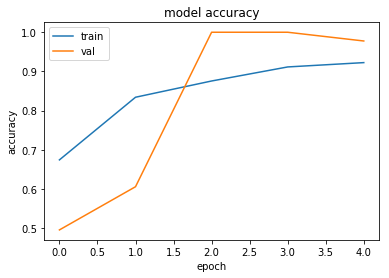

In [12]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

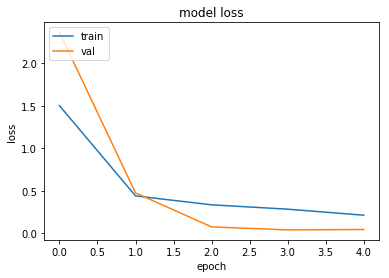

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()